<a href="https://colab.research.google.com/github/Yyh2005201/Kelly-YU-s-midterm-project-for-NYU-Data-Bootcamp/blob/main/Kelly_Yu_midterm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance pandas numpy matplotlib seaborn plotly networkx

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [3]:
sector_portfolios = {'Tech': ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'ADBE'],
    'Consumer Retail': ['AMZN', 'WMT', 'TGT', 'COST', 'HD'],
    'Financial Service': ['JPM', 'BAC', 'GS', 'V', 'MA'],
    'Health': ['JNJ', 'PFE', 'UNH', 'MRK', 'ABT'],
    'Energy Materials': ['XOM', 'CVX', 'COP', 'LIN', 'APD'],
    'Industrial Manufacturing': ['CAT', 'BA', 'HON', 'GE', 'MMM']}

# get the data for five years
# (the reason why I don't use specific date is due to the yfiance error of exact same date for several stocks at the same time)
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

# storage
stock_data = {}
failed_downloads = []

for sector, tickers in sector_portfolios.items():
    sector_data = {}
    for ticker in tickers:
        try:
            data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            if not data.empty and len(data) > 200:
                stock_data[ticker] = data
            else:
                failed_downloads.append(ticker)
        except Exception as e:
            failed_downloads.append(ticker)
            print(f"{ticker} - fail to download for: {e}")


In [4]:
# start clean our data
stock_data_clean = {}
for ticker, data in stock_data.items():
  # again use try to avoid error
    try:
        data_clean = data.copy()
        # handle multiple layers of column names
        if isinstance(data_clean.columns, pd.MultiIndex):
            new_columns = []
            for col in data_clean.columns:
              # if the second layer is a stock code
                if col[1] == ticker:
                  # we only use the first layer
                    new_columns.append(col[0])
                else:
                    new_columns.append(f"{col[0]}_{col[1]}")
            data_clean.columns = new_columns

        stock_data_clean[ticker] = data_clean

    except Exception as e:
        print(f"fail to clean {ticker} : {e}")

In [5]:
all_stock_data = []

for ticker, data in stock_data_clean.items():
    try:
        # reset index
        df_temp = data.reset_index()

        # give each ticker a sector
        sector = "whatsector"
        for sec, tickers in sector_portfolios.items():
            if ticker in tickers:
                sector = sec
                break

        # Add ticker and sctor
        df_temp['Ticker'] = ticker
        df_temp['Sector'] = sector

        required_cols = ['Date', 'Close', 'High', 'Low', 'Volume']
        # check whether all the columns we need are in our dataframe
        if all(col in df_temp.columns for col in required_cols):

          # add daily return: How many percent has it risen (or fallen) today compared to yesterday
          # remind: the first day is NAN so we have to remove all NAN at last
          df_temp['Daily_Return'] = df_temp['Close'].pct_change()
          # range of price
          df_temp['Daily_Range_Pct'] = (df_temp['High'] - df_temp['Low']) / df_temp['Close'] * 100
          # Volatility the higher the volatility, the more unstable the price is.
          df_temp['Volatility_50D'] = df_temp['Daily_Return'].rolling(50).std()
          # volume moving average: Determine whether the current trading volume is abnormal
          df_temp['Volume_MA_50'] = df_temp['Volume'].rolling(50).mean()
          # If this value is greater than 1, it indicates that the trading volume on that day is higher than the average of the past 10 days
          df_temp['Volume_Ratio'] = df_temp['Volume'] / df_temp['Volume_MA_50']
          # range of price
          df_temp['Daily_Range_Pct'] = (df_temp['High'] - df_temp['Low']) / df_temp['Close'] * 100

          # remove all NaN
          df_temp = df_temp.dropna()

          if not df_temp.empty:
              all_stock_data.append(df_temp)

    except Exception as e:
        print(f"fail {ticker} for: {e}")

# combine all as our final dataframe
if all_stock_data:
    df = pd.concat(all_stock_data, ignore_index=True)
    print(f"the final shape: {df.shape}")
else:
    print("nothing combine(error)")
    df = pd.DataFrame()

the final shape: (36150, 13)


In [6]:
# check our df
df

,Date,Close,High,Low,Open,Volume,Ticker,Sector,Daily_Return,Daily_Range_Pct,Volatility_50D,Volume_MA_50,Volume_Ratio
0,2021-01-07,127.567909,128.259737,124.586260,125.073458,109578200,AAPL,Tech,0.034123,2.879624,0.021775,1.104703e+08,0.991924
1,2021-01-08,128.668991,129.234143,126.895583,129.039251,105158200,AAPL,Tech,0.008631,1.817500,0.021738,1.107280e+08,0.949699
2,2021-01-11,125.677597,126.837131,125.209891,125.882227,100384500,AAPL,Tech,-0.023249,1.294773,0.020904,1.098569e+08,0.913775
3,2021-01-12,125.502190,126.369401,123.611859,125.209868,91951100,AAPL,Tech,-0.001396,2.197206,0.020334,1.087733e+08,0.845346
4,2021-01-13,127.538673,128.084333,125.200129,125.463205,88636800,AAPL,Tech,0.016227,2.261434,0.018586,1.067406e+08,0.830394
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36145,2025-10-17,152.639999,153.070007,151.270004,151.449997,4494000,MMM,Industrial Manufacturing,0.008124,1.179247,0.013816,2.821884e+06,1.592553
36146,2025-10-20,154.779999,156.070007,153.029999,153.229996,4230400,MMM,Industrial Manufacturing,0.014020,1.964084,0.013881,2.858964e+06,1.479697
36147,2025-10-21,166.639999,166.820007,152.800003,158.000000,7302200,MMM,Industrial Manufacturing,0.076625,8.413349,0.017503,2.937918e+06,2.485502
36148,2025-10-22,167.229996,169.179993,165.529999,167.160004,5275800,MMM,Industrial Manufacturing,0.003541,2.182619,0.017377,2.988470e+06,1.765385


In [7]:
import requests

In [8]:
api_key = '1737c4d68efff82785d433a0d6d3b08e'

In [9]:
url = 'https://api.stlouisfed.org/fred/series/observations'

### Below is just a sample for one macro factor, for the convinence, I will use for loop ###

In [10]:
###!!!a sample!!! this code is not what i use!!!###

#structure url and make request
params = {'series_id':'CPIAUCSL',
          'api_key': api_key,
         'file_type': 'json',
         'observation_start': start_date.strftime('%Y-%m-%d'),
         'observation_end': end_date.strftime('%Y-%m-%d')}
r = requests.get(url, params = params)

#turn into json
data = r.json()

start_date = datetime(2022, 3, 1)
end_date = datetime(2025, 3, 1)

#dataframe of observations
obs_df = pd.DataFrame(data['observations'])
obs_df.head()

# convert 'date' column to datetime
obs_df['date'] = pd.to_datetime(obs_df['date'])

# convert 'value' to numeric
obs_df['value'] = pd.to_numeric(obs_df['value'], errors='coerce')

# set 'date' as index
obs_df = obs_df.set_index('date')

# resample to daily frequency and forward-fill missing days
obs_df = obs_df.resample('D').ffill()

# reset index back to column
obs_df = obs_df.reset_index()

obs_df.head(4)


,date,realtime_start,realtime_end,value
0,2020-10-01,2025-10-23,2025-10-23,260.319
1,2020-10-02,2025-10-23,2025-10-23,260.319
2,2020-10-03,2025-10-23,2025-10-23,260.319
3,2020-10-04,2025-10-23,2025-10-23,260.319


In [11]:
macro_codes = {'TenYearRate': 'DGS10',        # Ten Year Treasury Constant Maturity Rate (daily)
               'FedFundsRate': 'FEDFUNDS',    # Federal Funds Effective Rate (daily)
               'CPI': 'CPIAUCSL',             # Consumer Price Index (monthly)
               'Sentiment': 'UMCSENT'         # University of Michigan: Consumer Sentiment (monthly)
}


# initialize an empty DataFrame for all macro data
macro_df = pd.DataFrame()

# here we can directly set our time
start_date = datetime(2022, 3, 1)
end_date = datetime(2025, 3, 1)


# loop through each macro series and download data
for name, code in macro_codes.items():
    url = 'https://api.stlouisfed.org/fred/series/observations'
    params = {'series_id': code,
              'api_key': api_key,
              'file_type': 'json',
              'observation_start': start_date.strftime('%Y-%m-%d'),
              'observation_end': end_date.strftime('%Y-%m-%d')}

    r = requests.get(url, params=params)
    data = r.json()

    # extract date and value columns only
    obs = pd.DataFrame(data['observations'])[['date', 'value']]

    # convert value to numeric safely (invalid values → NaN)
    obs['value'] = pd.to_numeric(obs['value'], errors='coerce')

    # rename for clarity
    obs = obs.rename(columns={'date': 'Date', 'value': name})

    # merge into master dataframe
    if macro_df.empty:
        macro_df = obs
    else:
        macro_df = pd.merge(macro_df, obs, on='Date', how='outer')

#align the combined dataset
macro_df = macro_df.sort_values('Date').reset_index(drop=True)

# fill missing values forward (each column independently)
macro_df = macro_df.fillna(method='ffill')

# optionally, also fill the very first NaNs with the first valid value
macro_df = macro_df.fillna(method='bfill')

macro_df['Date'] = pd.to_datetime(macro_df['Date'])
macro_df = macro_df.sort_values('Date').reset_index(drop=True)

# resample to daily frequency and forward-fill, since CPI & Sentiment are monthly
macro_df = macro_df.set_index('Date').resample('D').ffill().reset_index()

# check our output
print("Final macroeconomic dataset shape:", macro_df.shape)


Final macroeconomic dataset shape: (1097, 5)


In [12]:
macro_df.head()

,Date,TenYearRate,FedFundsRate,CPI,Sentiment
0,2022-03-01,1.72,0.2,287.467,59.4
1,2022-03-02,1.86,0.2,287.467,59.4
2,2022-03-03,1.86,0.2,287.467,59.4
3,2022-03-04,1.74,0.2,287.467,59.4
4,2022-03-05,1.74,0.2,287.467,59.4


In [13]:
# make the date column in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# define our required time
target_start = pd.Timestamp('2022-03-01')
target_end = pd.Timestamp('2025-03-01')

# filter our date
df_filtered = df[(df['Date'] >= target_start) & (df['Date'] <= target_end)].copy()

In [14]:
# check
df_filtered

,Date,Close,High,Low,Open,Volume,Ticker,Sector,Daily_Return,Daily_Range_Pct,Volatility_50D,Volume_MA_50,Volume_Ratio
288,2022-03-01,160.205612,163.543238,158.998184,161.678090,83474400,AAPL,Tech,-0.011628,2.837013,0.017441,94285888.0,0.885333
289,2022-03-02,163.503922,164.289246,159.960158,161.373739,79724800,AAPL,Tech,0.020588,2.647697,0.017683,91971730.0,0.866840
290,2022-03-03,163.179977,165.810812,162.512461,165.378883,76678400,AAPL,Tech,-0.001981,2.021296,0.017649,91355316.0,0.839343
291,2022-03-04,160.176147,162.512484,159.125788,161.471935,83737200,AAPL,Tech,-0.018408,2.114357,0.017608,91206342.0,0.918107
292,2022-03-07,156.377167,161.992217,156.121928,160.362671,96418800,AAPL,Tech,-0.023718,3.753930,0.017735,91292012.0,1.056158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35981,2025-02-24,144.105118,145.016421,142.510333,143.609843,3447500,MMM,Industrial Manufacturing,0.003449,1.739070,0.012796,3619888.0,0.952378
35982,2025-02-25,145.155090,146.165455,143.966434,144.055580,4358800,MMM,Industrial Manufacturing,0.007286,1.514946,0.012623,3642550.0,1.196634
35983,2025-02-26,146.036682,147.849389,140.420269,143.025419,5783400,MMM,Industrial Manufacturing,0.006073,5.087160,0.012626,3676428.0,1.573103
35984,2025-02-27,149.097504,151.118218,146.809337,147.364042,6576000,MMM,Industrial Manufacturing,0.020959,2.889975,0.012878,3749642.0,1.753767


In [15]:
# again, make the date column in datetime format
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])
macro_df['Date'] = pd.to_datetime(macro_df['Date'])

# Use merge for left join, so each row of stock data will be added with the corresponding macro data
df_with_macro = df_filtered.merge(macro_df,
                                  on='Date',
                                  how='left',  # from left to add columns
                                  suffixes=('', '_macro'))


In [16]:
# check our final dataframe
df_with_macro

,Date,Close,High,Low,Open,Volume,Ticker,Sector,Daily_Return,Daily_Range_Pct,Volatility_50D,Volume_MA_50,Volume_Ratio,TenYearRate,FedFundsRate,CPI,Sentiment
0,2022-03-01,160.205612,163.543238,158.998184,161.678090,83474400,AAPL,Tech,-0.011628,2.837013,0.017441,94285888.0,0.885333,1.72,0.20,287.467,59.4
1,2022-03-02,163.503922,164.289246,159.960158,161.373739,79724800,AAPL,Tech,0.020588,2.647697,0.017683,91971730.0,0.866840,1.86,0.20,287.467,59.4
2,2022-03-03,163.179977,165.810812,162.512461,165.378883,76678400,AAPL,Tech,-0.001981,2.021296,0.017649,91355316.0,0.839343,1.86,0.20,287.467,59.4
3,2022-03-04,160.176147,162.512484,159.125788,161.471935,83737200,AAPL,Tech,-0.018408,2.114357,0.017608,91206342.0,0.918107,1.74,0.20,287.467,59.4
4,2022-03-07,156.377167,161.992217,156.121928,160.362671,96418800,AAPL,Tech,-0.023718,3.753930,0.017735,91292012.0,1.056158,1.78,0.20,287.467,59.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22585,2025-02-24,144.105118,145.016421,142.510333,143.609843,3447500,MMM,Industrial Manufacturing,0.003449,1.739070,0.012796,3619888.0,0.952378,4.40,4.33,319.775,64.7
22586,2025-02-25,145.155090,146.165455,143.966434,144.055580,4358800,MMM,Industrial Manufacturing,0.007286,1.514946,0.012623,3642550.0,1.196634,4.30,4.33,319.775,64.7
22587,2025-02-26,146.036682,147.849389,140.420269,143.025419,5783400,MMM,Industrial Manufacturing,0.006073,5.087160,0.012626,3676428.0,1.573103,4.25,4.33,319.775,64.7
22588,2025-02-27,149.097504,151.118218,146.809337,147.364042,6576000,MMM,Industrial Manufacturing,0.020959,2.889975,0.012878,3749642.0,1.753767,4.29,4.33,319.775,64.7


Now let's begin our questions!

1. Industry Linkage Analysis:

Question 1: Do Industries Move in Harmony - or Does Market Rhythm Differ Across Sectors?

For this question we only need the first dataframe (without macro data), and we can draw a heatmap for visualizing.

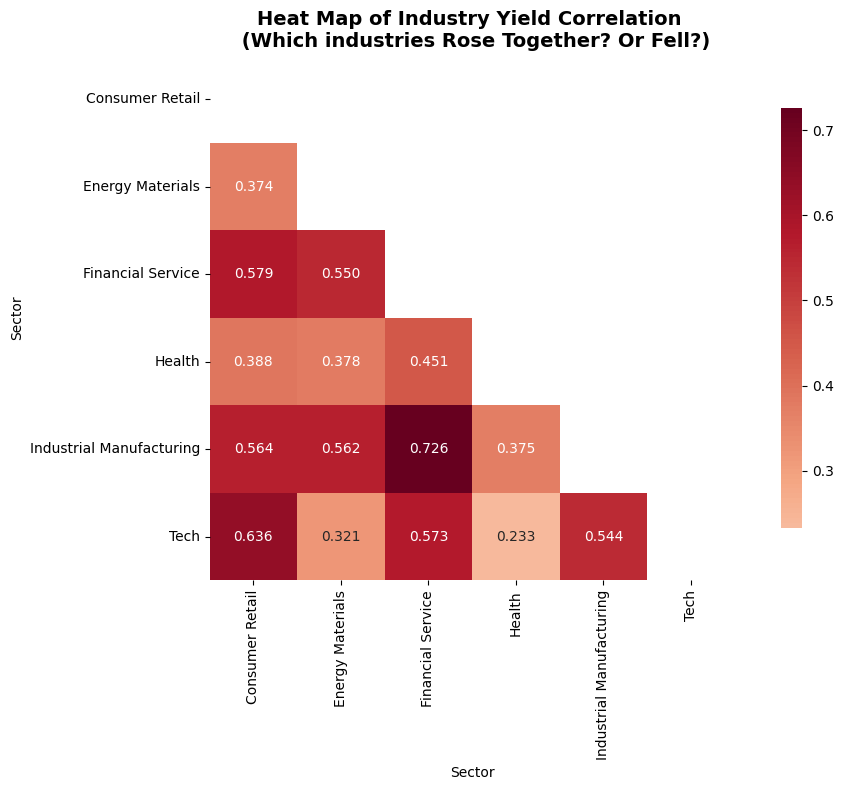

Findings:
The industries with the strongest relevance are:
  Financial Service  with  Industrial Manufacturing: 0.726

 The industry pairs with the weakest correlation:
  Health  with  Tech: 0.233


In [17]:
# Calculate the average daily rate of return for each industry
sector_daily_returns = df_filtered.groupby(['Sector', 'Date'])['Daily_Return'].mean().reset_index()
sector_pivot = sector_daily_returns.pivot(index='Date', columns='Sector', values='Daily_Return')

# Calculate the correlation matrix between industries
sector_correlation = sector_pivot.corr()

plt.figure(figsize=(11, 8))
mask = np.triu(np.ones_like(sector_correlation, dtype=bool))
sns.heatmap(sector_correlation, mask=mask, # here I add mask to hide the upper triangular part since the heat map is symmetric and the diagonal is just 1
            annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.3f', cbar_kws={"shrink": .8})
plt.title('Heat Map of Industry Yield Correlation \n (Which industries Rose Together? Or Fell?)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Findings:")

# Find the industry pairs with the highest relevance
corr_pairs = []
for i in range(len(sector_correlation.columns)):
    for j in range(i+1, len(sector_correlation.columns)):
        corr_pairs.append((sector_correlation.columns[i], sector_correlation.columns[j],
                          sector_correlation.iloc[i, j]))

corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)

print("The industries with the strongest relevance are:")
for sector1, sector2, corr in corr_pairs_sorted[:1]:
    print(f"  {sector1}  with  {sector2}: {corr:.3f}")

print("\n The industry pairs with the weakest correlation:")
for sector1, sector2, corr in corr_pairs_sorted[-1:]:
    print(f"  {sector1}  with  {sector2}: {corr:.3f}")

This question explores whether industries exhibit synchronized market behavior, and what this says about diversification potential. According to the heatmap, it's clear that the darker the color is, the stronger the relationship is. We found the industries with the strongest relevance are: Financial Service Sector with Industrial Manufacturing Sector; the industry pairs with the weakest correlation are: Health Sector with Tech Sector (just as I wrote below the plot). While certain industries exhibit strong comovement, others move far more independently. This asymmetry in correlation suggests that diversification benefits still exist across industries: investors who combine highly cyclical sectors (e.g., Financials, Industrials) with defensive or innovation-driven ones (e.g., Health, Tech) can meaningfully reduce portfolio volatility. In other words, the market does not move as a single rhythm but as an ensemble of distinct sectoral beats, allowing diversification to remain a powerful risk-management tool.


Let's go deeper, focus on one specific sector - Tech.

Question 2: Is Tech's Relationship with Other Sectors a Lasting Alliance or a Shifting Correlation?

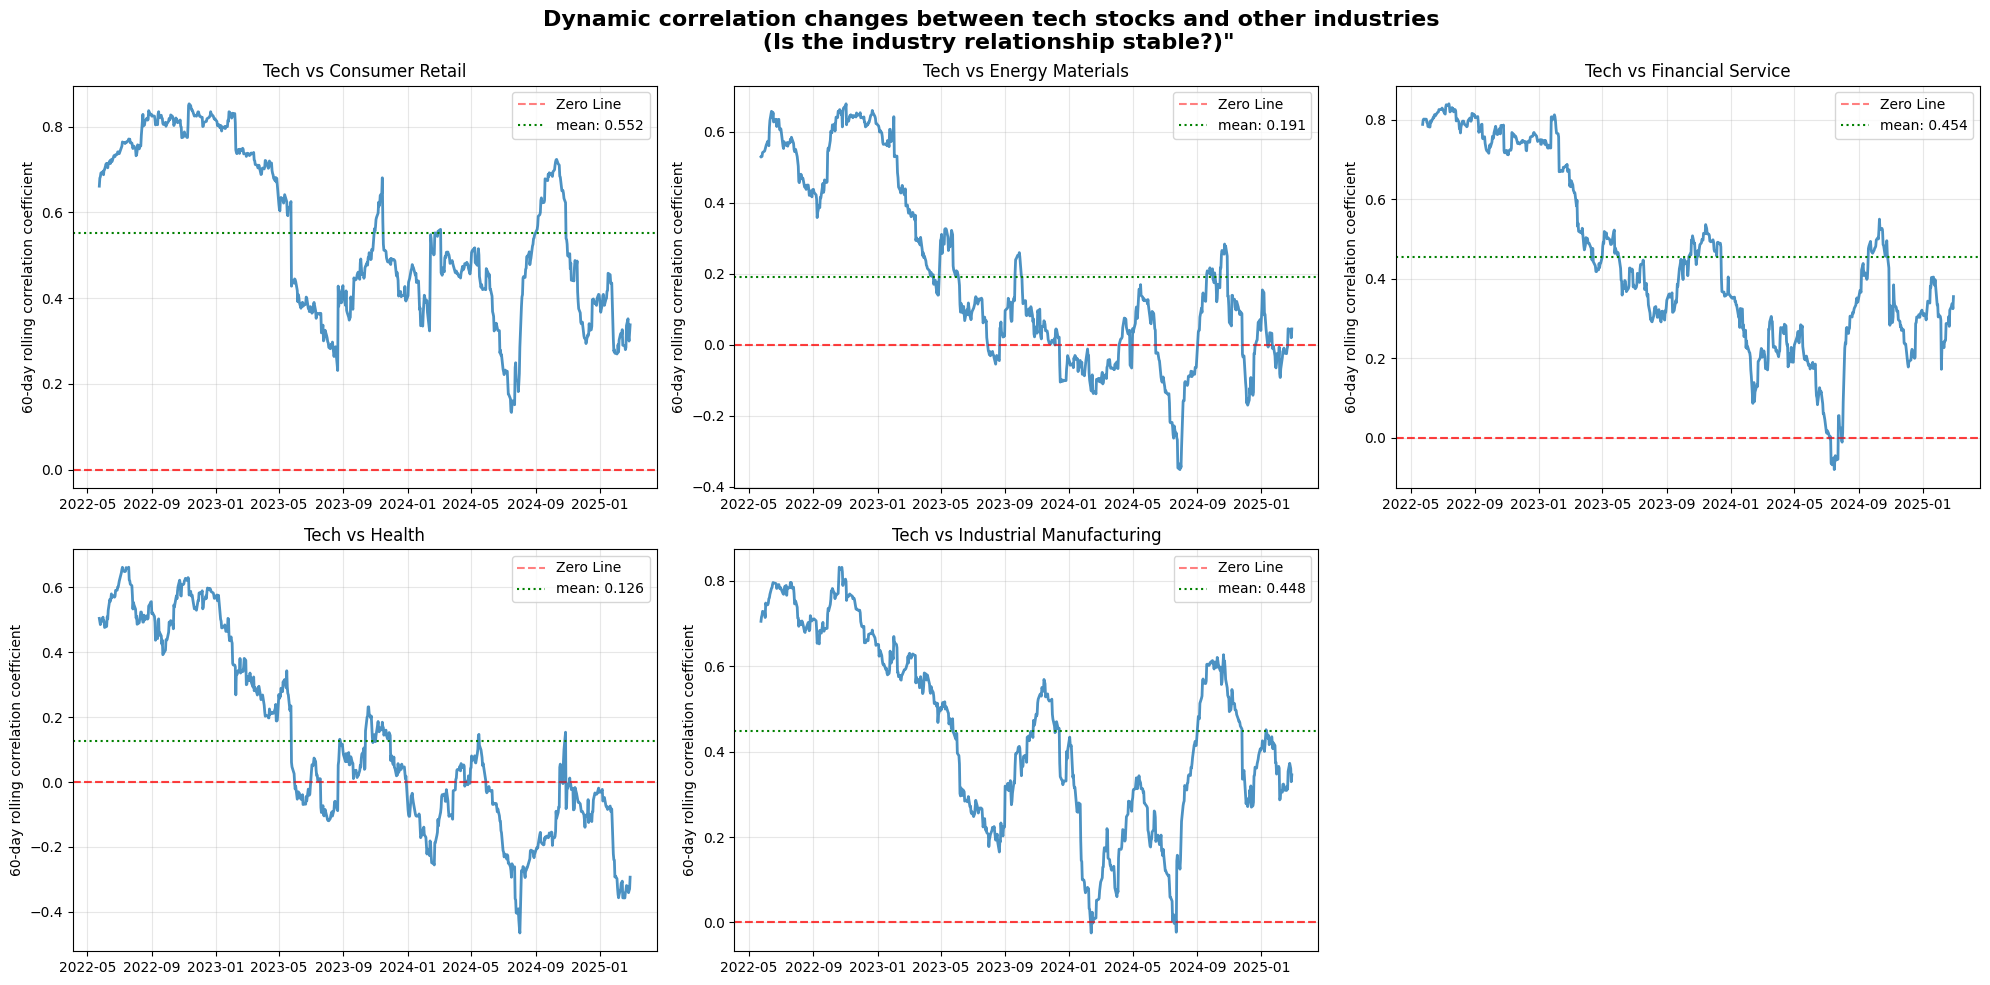

Findings:
  Tech vs Consumer Retail: correlation volatility = 0.1875
  Tech vs Energy Materials: correlation volatility = 0.2606
  Tech vs Financial Service: correlation volatility = 0.2292
  Tech vs Health: correlation volatility = 0.2868
  Tech vs Industrial Manufacturing: correlation volatility = 0.2149


In [18]:
rolling_window = 60  # 3 month
tech_sector = 'Tech'

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Dynamic correlation changes between tech stocks and other industries \n (Is the industry relationship stable?)"', fontsize=16, fontweight='bold')

other_sectors = [s for s in sector_correlation.columns if s != tech_sector]

for i, sector in enumerate(other_sectors[:]):
    row, col = i // 3, i % 3
    rolling_corr = sector_pivot[tech_sector].rolling(rolling_window).corr(sector_pivot[sector])

    # adding our zero line to the legend
    axes[row, col].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Zero Line')
    axes[row, col].plot(rolling_corr.index, rolling_corr.values, linewidth=2, alpha=0.8)
    axes[row, col].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[row, col].set_title(f'{tech_sector} vs {sector}')
    axes[row, col].set_ylabel('60-day rolling correlation coefficient')
    axes[row, col].grid(True, alpha=0.3)

    # adding the average line
    mean_corr = rolling_corr.mean()
    axes[row, col].axhline(y=mean_corr, color='green', linestyle=':',
                          label=f'mean: {mean_corr:.3f}')
    axes[row, col].legend()


# hide the last plot since we only have five other sectors
if len(other_sectors) < 6:
    axes[1, 2].set_visible(False)

plt.tight_layout()
plt.show()

# print some key information
print("Findings:")
for sector in other_sectors:
    rolling_corr = sector_pivot[tech_sector].rolling(rolling_window).corr(sector_pivot[sector])
    volatility = rolling_corr.std()
    print(f"  {tech_sector} vs {sector}: correlation volatility = {volatility:.4f}")

I listed the findings at the bottom of the plot. These figures seem to have the same kind of shape. Thus, in order to see how similar are they, I create a plot that puts all these lines together. Additionally, I want to know what specific are some turning points (like very bottom point in around 2024-08), so I create an interactive plot by using Bokeh.

In [24]:
# use bokeh for creative plot
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool, Span
from bokeh.palettes import Category10_6

output_notebook()

rolling_window = 60
tech_sector = 'Tech'
# get sectors other than Tech
other_sectors = [s for s in sector_correlation.columns if s != tech_sector]
colors = Category10_6
# draw plot
p = figure(title='Dynamic Correlation: Tech vs Other Industries',
           x_axis_type='datetime',
           x_axis_label='Date',
           y_axis_label='60-day Rolling Correlation Coefficient',
           width=1000,
           height=500,
           tools="pan,wheel_zoom,box_zoom,reset,save")

# draw the zero correlation reference line
zero_line = Span(location=0, dimension='width', line_color='red',
                 line_dash='dashed', line_alpha=0.5)
p.add_layout(zero_line)

# only draw lines, not scatter points
for i, sector in enumerate(other_sectors):
    rolling_corr = sector_pivot[tech_sector].rolling(rolling_window).corr(sector_pivot[sector])

    source_data = pd.DataFrame({
        'date': rolling_corr.index,
        'correlation': rolling_corr.values,
        'sector_pair': f'{tech_sector} vs {sector}'
    }).dropna()

    source = ColumnDataSource(source_data)

    # draw line
    line = p.line(x='date', y='correlation', source=source,
                  line_width=3, color=colors[i],
                  legend_label=f'{tech_sector} vs {sector}',
                  alpha=0.8)

# setting our hover tool
hover = HoverTool(tooltips=[("Sector Pair", "@sector_pair"),
                            ("Date", "@date{%F}"),
                            ("Correlation", "@correlation{0.3f}")],
                  formatters={'@date': 'datetime'},
                  mode='vline'  # The vertical mode displays all intersecting data points
                 )
p.add_tools(hover)

p.legend.location = "top_left"
p.legend.click_policy = "hide"
p.grid.grid_line_alpha = 0.3

output_notebook()
show(p)

# save plot to put into github
output_file("bokeh_plot.html")
save(p)


'/content/bokeh_plot.html'

This is an interactive plot where you can simple see the correlation between Tech with other industries at a glance and also figure out a specific sector's realation with Tech by hiding other lines and moving you mouse to check the point value.

 While all industry pairs exhibit similar overall directional movements and common turning points, it is the significant disparity in their correlation coefficient ranges that proves most critical. This divergence underscores the dynamic and heterogeneous nature of inter-industry relationships, as certain pairs (like Tech vs. Consumer Retail), maintain a consistently high positive correlation, while others, such as Tech vs. Energy Materials, frequently traverse from positive to negative territory, offering substantially different diversification and hedging potential across market regimes.

Question 3:  Does Trading Volume Amplify or Dampen Price Volatility? (When is the best time to invest?)

Liquidity vs Volatility Summary Statistics:
  Liquidity_Group      mean       std  count
0      Low Volume  1.684329  0.707980   6777
1   Medium Volume  2.033994  0.934924   9036
2     High Volume  2.706590  1.427597   6777


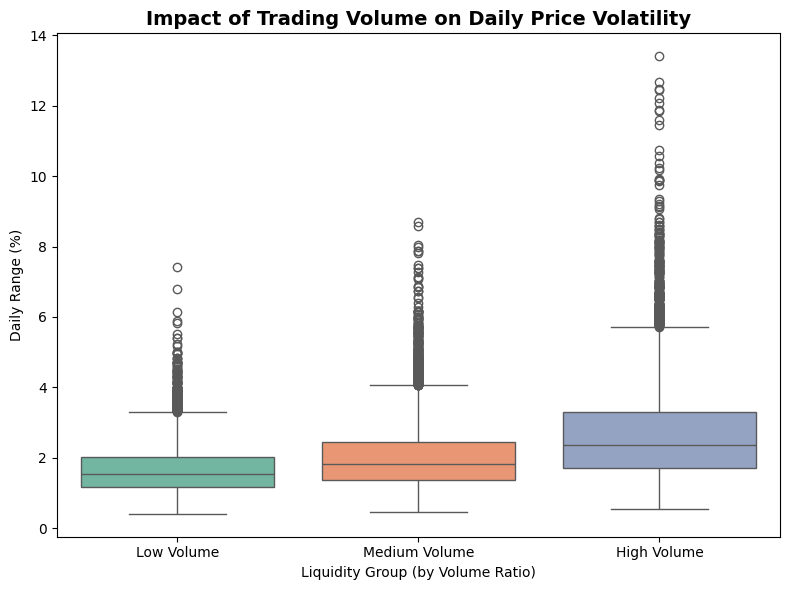

In [20]:
# select relevant columns
cols_needed = ['Volume_Ratio', 'Daily_Range_Pct', 'Sector']
assert all(col in df_filtered.columns for col in cols_needed), " Missing required columns"

# drop missing values
df_liquidity = df_filtered.dropna(subset=['Volume_Ratio', 'Daily_Range_Pct'])

# define quantile thresholds for volume ratio
low_threshold = df_liquidity['Volume_Ratio'].quantile(0.3)
high_threshold = df_liquidity['Volume_Ratio'].quantile(0.7)

# categorize days based on liquidity level
df_liquidity['Liquidity_Group'] = pd.cut(
    df_liquidity['Volume_Ratio'],
    bins=[-float('inf'), low_threshold, high_threshold, float('inf')],
    labels=['Low Volume', 'Medium Volume', 'High Volume']
)

# compute average daily volatility per group
vol_stats = (
    df_liquidity.groupby('Liquidity_Group')['Daily_Range_Pct']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)

print("Liquidity vs Volatility Summary Statistics:")
print(vol_stats)

# visualization: Boxplot of volatility under different liquidity conditions
plt.figure(figsize=(8,6))
sns.boxplot(data=df_liquidity, x='Liquidity_Group', y='Daily_Range_Pct', palette='Set2')
plt.title("Impact of Trading Volume on Daily Price Volatility", fontsize=14, fontweight='bold')
plt.xlabel("Liquidity Group (by Volume Ratio)")
plt.ylabel("Daily Range (%)")
plt.tight_layout()
plt.show()


The results show a clear positive relationship between liquidity and volatility. When liquidity increases, volatility also rises suggesting that active trading amplifies market fluctuations rather than stabilizing prices. Conversely, during low-volume periods, prices are more stable but may reflect less efficient information processing. From an investing perspective, this implies that high-liquidity days may offer higher short-term trading opportunities, while low-liquidity periods are better suited for long-term stability seekers.


2. The analysis of macro factors and the stocks.

Recall our Q1.2's similar shapes. Why these shapes resemble each other? Does that imply the influence from some shared macroeconomic cycles? Thus, the second part I'm going to analyze the relationships between some macrofractors and our stocks.

Question 4: Which macro factor contributes the most when explaining the changes in stock returns generally?

To answer this question, I draw a bar chart showing the relation in descending order by correlation.

In [21]:
# prepare factors
macro_factors = ['TenYearRate', 'FedFundsRate', 'CPI', 'Sentiment']

# calculate the overall correlation
overall_correlation = df_with_macro[macro_factors + ['Daily_Return']].corr()['Daily_Return'].drop('Daily_Return')

# take absolute value
importance_corr = overall_correlation.abs().sort_values(ascending=False)

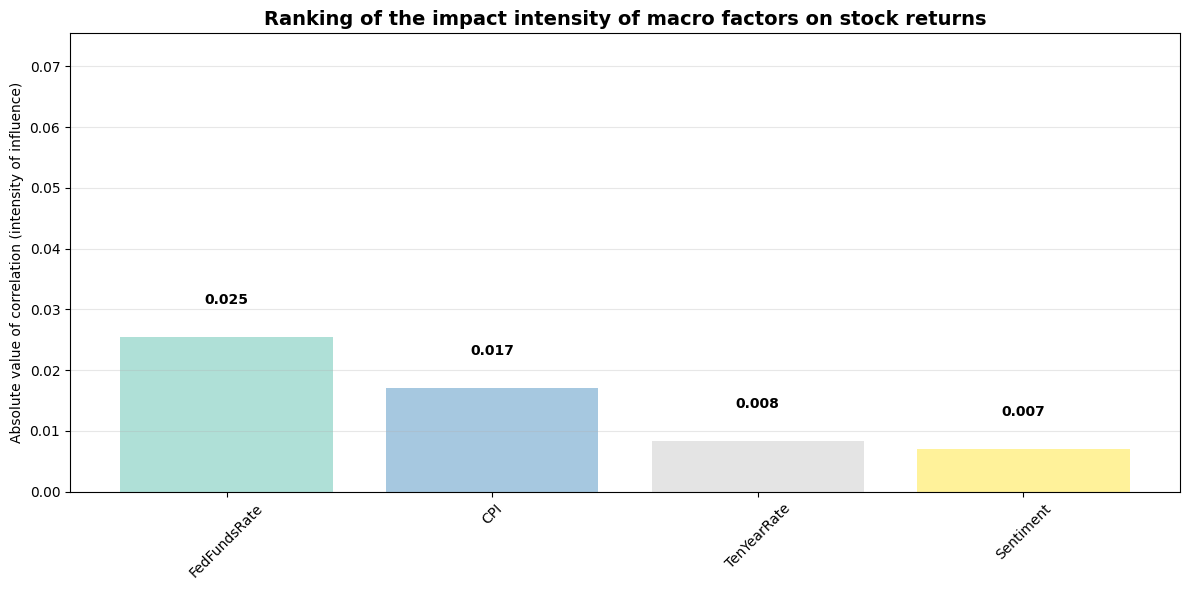

The most influential macro factors: FedFundsRate (intensity: 0.025)
The least influential macro factors: Sentiment (intensity: 0.007)


In [22]:
# draw the plot
plt.figure(figsize=(12, 6))

colors = plt.cm.Set3(np.linspace(0, 1, len(importance_corr)))
bars = plt.bar(importance_corr.index, importance_corr.values, color=colors, alpha=0.7)

for bar, value in zip(bars, importance_corr.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.title('Ranking of the impact intensity of macro factors on stock returns', fontsize=14, fontweight='bold')
plt.ylabel('Absolute value of correlation (intensity of influence)')
plt.ylim(0, importance_corr.max() + 0.05)
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"The most influential macro factors: {importance_corr.index[0]} (intensity: {importance_corr.iloc[0]:.3f})")
print(f"The least influential macro factors: {importance_corr.index[-1]} (intensity: {importance_corr.iloc[-1]:.3f})")

The bar plot clearly shows in a ranking way that The Fed Fund Rate is identified as the "most influential macro factors", with an "intensity of influence" score of 0.025. This is followed by Consumer Price Index (CPI) at 0.017. Conversely, the Ten Year Rate (0.008) and Consumer Sentiment (0.007) have a significantly weaker impact, with Sentiment ranked as the "least influential". A very important takeaway, which is not in line with my former thinking, is that among the factors analyzed, Sentiment has the weakest relationship with stock returns. I think it is worth mentioning because "Sentiment" is often discussed in financial media, but data suggests that its actual impact on returns is minimal compared to more concrete economic factors like the Fed Fund Rate and CPI.

Question 5: What is the relationships between macro factors and the sotck from different industries?


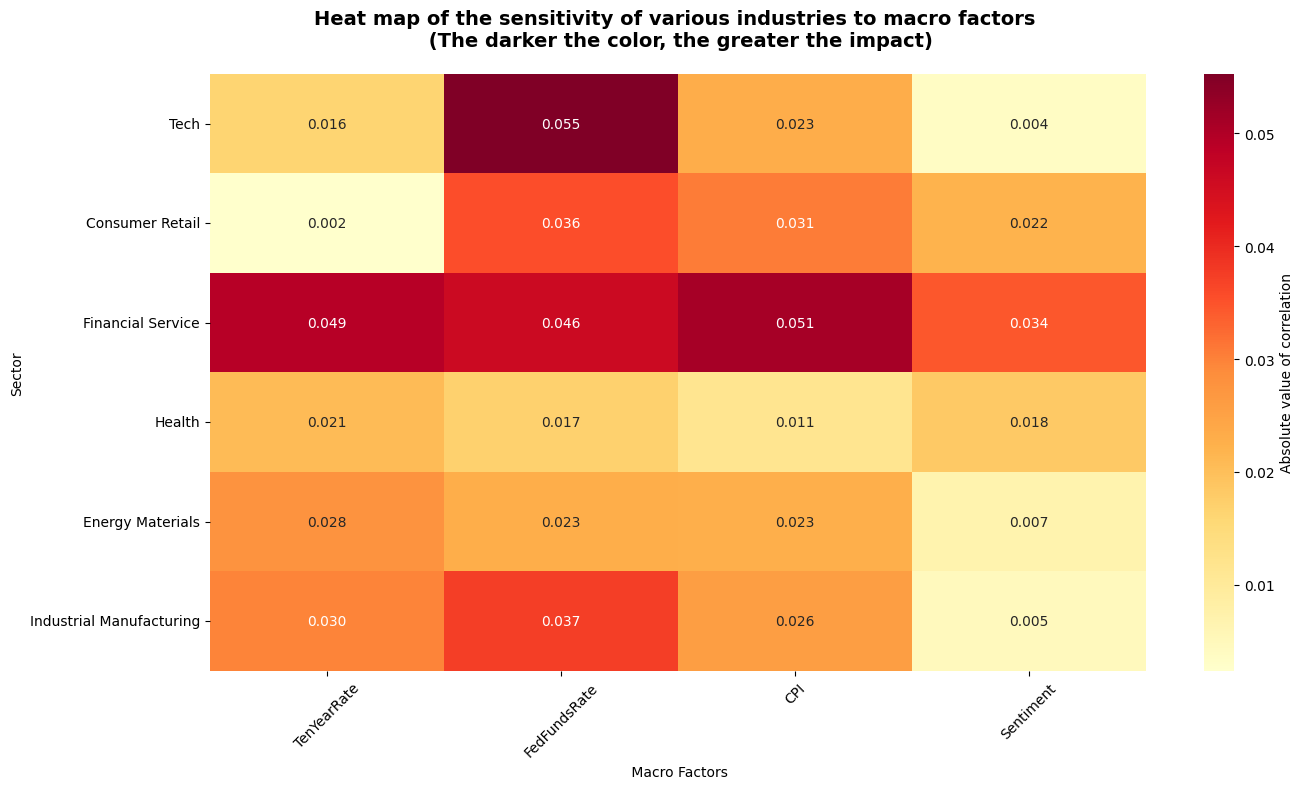

  TenYearRate:
    Most sensitive sector: Financial Service (0.049)
    The least sensitive sector: Consumer Retail (0.002)
  FedFundsRate:
    Most sensitive sector: Tech (0.055)
    The least sensitive sector: Health (0.017)
  CPI:
    Most sensitive sector: Financial Service (0.051)
    The least sensitive sector: Health (0.011)
  Sentiment:
    Most sensitive sector: Financial Service (0.034)
    The least sensitive sector: Tech (0.004)


In [23]:
sector_importance = {}
# calculate correlation
for sector in df_with_macro['Sector'].unique():
    sector_data = df_with_macro[df_with_macro['Sector'] == sector]
    sector_corr = sector_data[macro_factors + ['Daily_Return']].corr()['Daily_Return'].drop('Daily_Return')
    sector_importance[sector] = sector_corr.abs()

sector_importance_df = pd.DataFrame(sector_importance).T

plt.figure(figsize=(14, 8))
sns.heatmap(sector_importance_df,
            annot=True,
            cmap='YlOrRd',
            fmt='.3f',
            cbar_kws={'label': 'Absolute value of correlation'})

plt.title('Heat map of the sensitivity of various industries to macro factors \n (The darker the color, the greater the impact)',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel(' Macro Factors')
plt.ylabel('Sector')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

for factor in macro_factors:
    most_sensitive_sector = sector_importance_df[factor].idxmax()
    least_sensitive_sector = sector_importance_df[factor].idxmin()
    print(f"  {factor}:")
    print(f"    Most sensitive sector: {most_sensitive_sector} ({sector_importance_df[factor].max():.3f})")
    print(f"    The least sensitive sector: {least_sensitive_sector} ({sector_importance_df[factor].min():.3f})")

While the previous analysis provided a overall ranking of macro factors towards stocks, this heat map provides a far more precise, accurate, and actionable breakdown by industries. This sector-level view reveals that the impact of macro factors is not uniform. For instance, the Fed Fund Rate, while impactful overall, is shown here to be the single most dominant factor for the Tech sector, with a sensitivity score of 0.055. In contrast, the Financial Service sector shows the broadest sensitivity, ranking as the "Most sensitive sector" for three of the four factors: TenYearRate (0.049), CPI (0.051), and Sentiment (0.034). This detailed view also identifies defensive sectors, such as Health, which is the "least sensitive" to both CPI and the Fed Fund Rate.(I listed the most sensitive and least sensitive sector directly below the plot.)

Additionally, this sector-specific sensitivity analysis allows an investor to move from general market observation to precise portfolio construction and risk management. An investor can now see exactly where macro risk is concentrated in their holdings; a portfolio heavily weighted in Tech and Financial Service stocks, for example, is exceptionally vulnerable to surprises in inflation and interest rate policy. Conversely, an investor seeking to build a defensive portfolio could overweight sectors like Health, which this data identifies as being the most insulated from those same factors. This analysis also helps filter market noise; it suggests a Tech investor can largely disregard "Sentiment" (the sector's least sensitive factor at 0.004) and focus instead on what truly matters to their holdings: the Fed Fund Rate.